<img align="left" src = https://linea.org.br/wp-content/themes/LIneA/imagens/logo-header.jpg width=100 style="padding: 20px"> 


<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=160 style="padding: 20px">  

# Photo-z Server - Tutorial Notebook

**Contact author**: Julia Gschwend ([julia@linea.org.br](mailto:julia@linea.org.br)) 

**Last verified run**: 2022-10-28 <br>



## 0. Introduction
The Photo-z (PZ) Server is an online service available for the LSST Community to host and share lightweight photo-z related data products. The upload and download of data and metadata can be done at the website https://pz-server.linea.org.br/. There, you will find two separate pages containing a list of data products each: one for LSST Data Management's oficial data products, and other for user-generated data products. **The registered data products can also be accessed directly from Python code using the PZ Server's data access API, as demonstrated below.**

The PZ Server is developed and delivered as part of the in-kind contribution program BRA-LIN, from LIneA to the Rubin Observatory's LSST. The service is hosted in the Brazilian IDAC, not directly connected to the [Rubin Science Platform (RSP)](https://data.lsst.cloud/). However, it requires RSP credentials for user's authentication. 

For a comprehensive documentation about the PZ Server, please visit the [PZ Server's documentation page](https://linea-it.github.io/pz-lsst-inkind-doc/). There, you will find also an overview of all LIneA's contributions related to Photo-zs.


### Installation

The PZ Server API is avalialble on **pip** as  `pz-server-lib`. To install the API and its dependencies, type, on the Terminal:  

<font style="background-color:black; color:white;" face="Courier New"> $ pip install pz-server-lib </font>  

You might need to restart the kernel on the notebook to incorporate the new library. 

### Imports and Setup

In [1]:
from pz_server import PzServer, pz_plots
#import pandas as pd
%reload_ext autoreload 
%autoreload 2

The connection with the PZ Server from Python code is done by an object of the class `PzServer`. To get authorization to define an instance of `PzServer`, the users must provide an **API Token** generated on the top right menu on the [PZ Server website](https://pz-server-dev.linea.org.br/). 
<font color=red> to do: check link URL </font>

<img src="./images/ScreenShotTokenMenu.png" width=150pt align="top"/> <img src="./images/ScreenShotTokenGenerator.png" width=300pt/>

In [2]:
pz_server = PzServer(token="<paste your API Token here>") 

In [3]:
pz_server = PzServer(token="80cb575a78740f5ab7f03524607e0d67e9e2dd4c", host="pz-dev") 

### Get basic info from PZ Server

Besides providing access to data and metadata, the object `pz_server` also brings useful functions for users to navigate through the available contents. The functions with the preffix "get_" return the result of a query on the PZ Server database as a Python dictionary, and are most useful to be used programatically out of the Jupyter environment (see the API documentatio here). Those with the preffix "display_" just show the results as a styled [_Pandas DataFrames_](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). For instance:

Display the list of product types supported with a short description;

In [4]:
pz_server.display_product_types()

product_type,description
Spec-z Catalog,Catalog of spectroscopic redshifts and positions (usually equatorial coordinates).
Training Set,"Training set for photo-z algorithms (tabular data). It usually contains magnitudes, errors, and true redshifts."
Validation Set,"Validation/test set for photo-z algorithms (tabular data). It usually contains magnitudes, errors, and true redshifts."
Validation Results,Results of a photo-z validation procedure (free format). Usually contains photo-z estimates (single estimates and/or pdf) of a validation set and photo-z validation metrics.
Photo-z Table,"Results of a photo-z estimation procedure. If the data is larger than the file upload limit (200MB), the product entry stores only the metadata (instructions on accessing the data should be provided in the description field."


Display the list of users who uploaded data products to the server;

In [5]:
pz_server.display_users()

username,user
crisingulani,Cristiano Singulani
singulani,
glaubervila,Glauber Costa Vila-Verde
gverde,
Gschwend,Julia Gschwend
admin,


Display the list of data releases available at the time; 

In [6]:
pz_server.display_releases()

release,description
LSST DP0,LSST Data Preview 0


---
Display all data products available (WARNING: this list can rapdly grow during the survey's operation). 

In [7]:
pz_server.display_products_list() 

id,internal_name,product_name,product_type,survey,release,uploaded_by,official_product,description,created_at
24,24_pz_validation_goldenspike_knn,pz validation goldenspike knn,Validation Results,None,None,Gschwend,False,Results of photoz validation created with RAIL's goldenspike example notebook. Test upload zip file.,2022-10-28T14:36:55.899181Z
22,22_pz_validation_goldenspike_bpz,pz validation goldenspike bpz,Validation Results,None,None,Gschwend,False,Results of photoz validation created with RAIL's goldenspike example notebook. Test upload zip file.,2022-10-28T14:19:41.936586Z
21,21_pz_validation_goldenspike_fzboost,pz validation goldenspike fzboost,Validation Results,None,None,Gschwend,False,Results of photoz validation created with RAIL's goldenspike example notebook. Test upload zip file.,2022-10-28T14:02:18.647278Z
20,20_goldenspike_test,goldenspike test,Validation Set,,None,Gschwend,False,Validation (test) set created with RAIL's goldenspike example notebook (simulated data). Test upload HDF5 file.,2022-10-28T13:08:32.945942Z
19,19_goldenspike_test,goldenspike test,Validation Set,,None,Gschwend,False,Validation (test) set created with RAIL's goldenspike example notebook (simulated data). Test upload parquet file.,2022-10-28T13:07:03.403975Z
16,16_goldenspike_train,goldenspike train,Training Set,None,None,Gschwend,False,Training set created with RAIL's goldenspike example notebook (simulated data). Test upload FITS file.,2022-10-28T12:55:31.431617Z
14,14_goldenspike_train,goldenspike train,Training Set,None,None,Gschwend,False,Training set created with RAIL's goldenspike example notebook (simulated data). Test upload CSV file.,2022-10-28T12:53:28.365934Z
10,10_valid_sample_dp0_tiny,Valid sample DP0 tiny,Validation Set,LSST,LSST DP0,Gschwend,False,"A subsample of DP0 data with true redshifts and magnitudes to validate pz codes. ""DP0 tiny"" means the tiny fraction of DP0 used to test algorithms in the LIneA portal.",2022-10-17T16:05:50.808523Z
9,9_train_sample_dp0_tiny,Train sample DP0 tiny,Training Set,LSST,LSST DP0,Gschwend,False,"A subsample of DP0 data with true redshifts and magnitudes to train pz codes. ""DP0 tiny"" means the tiny fraction of DP0 used to test algorithms in the LIneA portal.",2022-10-17T16:04:32.903542Z
8,8_example_train_set,True-z sample DP0 tiny,Spec-z Catalog,LSST,LSST DP0,Gschwend,False,"A subsample of DP0 data with true redshifts. ""DP0 tiny"" means the tiny fraction of DP0 used to test algorithms in the LIneA portal.",2022-10-17T15:43:38.582001Z


The information about product type, users, and releases shown above can be used to filter the data products of interest for your search. For that, the function `list_products` receives as argument a dictionary mapping the products attributes to their values. 

In [8]:
pz_server.display_products_list(filters={"release": "LSST DP0", 
                                 "product_type": "Spec-z Catalog",
                                 "uploaded_by": "Gschwend"})

id,internal_name,product_name,product_type,survey,release,uploaded_by,official_product,description,created_at
8,8_example_train_set,True-z sample DP0 tiny,Spec-z Catalog,LSST,LSST DP0,Gschwend,False,"A subsample of DP0 data with true redshifts. ""DP0 tiny"" means the tiny fraction of DP0 used to test algorithms in the LIneA portal.",2022-10-17T15:43:38.582001Z
6,6_true_redshifts,True Redshifts,Spec-z Catalog,LSST,LSST DP0,Gschwend,False,"""Spec-z""-like catalog with true redshifts from LSST DP0 for tests.",2022-10-17T15:31:05.251962Z


It also works if we type a string pattern that is part of the value. For instance, just "DP0" instead of "LSST DP0": 

In [9]:
pz_server.display_products_list(filters={"release": "DP0"})

id,internal_name,product_name,product_type,survey,release,uploaded_by,official_product,description,created_at
10,10_valid_sample_dp0_tiny,Valid sample DP0 tiny,Validation Set,LSST,LSST DP0,Gschwend,False,"A subsample of DP0 data with true redshifts and magnitudes to validate pz codes. ""DP0 tiny"" means the tiny fraction of DP0 used to test algorithms in the LIneA portal.",2022-10-17T16:05:50.808523Z
9,9_train_sample_dp0_tiny,Train sample DP0 tiny,Training Set,LSST,LSST DP0,Gschwend,False,"A subsample of DP0 data with true redshifts and magnitudes to train pz codes. ""DP0 tiny"" means the tiny fraction of DP0 used to test algorithms in the LIneA portal.",2022-10-17T16:04:32.903542Z
8,8_example_train_set,True-z sample DP0 tiny,Spec-z Catalog,LSST,LSST DP0,Gschwend,False,"A subsample of DP0 data with true redshifts. ""DP0 tiny"" means the tiny fraction of DP0 used to test algorithms in the LIneA portal.",2022-10-17T15:43:38.582001Z
6,6_true_redshifts,True Redshifts,Spec-z Catalog,LSST,LSST DP0,Gschwend,False,"""Spec-z""-like catalog with true redshifts from LSST DP0 for tests.",2022-10-17T15:31:05.251962Z


It also allows the search for multiple strings by adding the suffix `__or` (two underscores + "or") to the searh key. For instance, to get training and validation sets in the same search:

In [10]:
pz_server.display_products_list(filters={"product_type__or": ["training set", "validation set"]})

id,internal_name,product_name,product_type,survey,release,uploaded_by,official_product,description,created_at
20,20_goldenspike_test,goldenspike test,Validation Set,,None,Gschwend,False,Validation (test) set created with RAIL's goldenspike example notebook (simulated data). Test upload HDF5 file.,2022-10-28T13:08:32.945942Z
19,19_goldenspike_test,goldenspike test,Validation Set,,None,Gschwend,False,Validation (test) set created with RAIL's goldenspike example notebook (simulated data). Test upload parquet file.,2022-10-28T13:07:03.403975Z
16,16_goldenspike_train,goldenspike train,Training Set,None,None,Gschwend,False,Training set created with RAIL's goldenspike example notebook (simulated data). Test upload FITS file.,2022-10-28T12:55:31.431617Z
14,14_goldenspike_train,goldenspike train,Training Set,None,None,Gschwend,False,Training set created with RAIL's goldenspike example notebook (simulated data). Test upload CSV file.,2022-10-28T12:53:28.365934Z
10,10_valid_sample_dp0_tiny,Valid sample DP0 tiny,Validation Set,LSST,LSST DP0,Gschwend,False,"A subsample of DP0 data with true redshifts and magnitudes to validate pz codes. ""DP0 tiny"" means the tiny fraction of DP0 used to test algorithms in the LIneA portal.",2022-10-17T16:05:50.808523Z
9,9_train_sample_dp0_tiny,Train sample DP0 tiny,Training Set,LSST,LSST DP0,Gschwend,False,"A subsample of DP0 data with true redshifts and magnitudes to train pz codes. ""DP0 tiny"" means the tiny fraction of DP0 used to test algorithms in the LIneA portal.",2022-10-17T16:04:32.903542Z


To fetch the results of a search and attribute to a variable, just change the preffix "display_" by "get_", like this:  

In [11]:
search_results = pz_server.get_products_list(filters={"product_type": "results"}) # PZ Validation results
search_results

[{'id': 24,
  'release': None,
  'release_name': None,
  'product_type': 4,
  'product_type_name': 'Validation Results',
  'uploaded_by': 'Gschwend',
  'internal_name': '24_pz_validation_goldenspike_knn',
  'display_name': 'pz validation goldenspike knn',
  'official_product': False,
  'survey': None,
  'pz_code': 'knn',
  'description': "Results of photoz validation created with RAIL's goldenspike example notebook. Test upload zip file.",
  'created_at': '2022-10-28T14:36:55.899181Z',
  'status': 1},
 {'id': 22,
  'release': None,
  'release_name': None,
  'product_type': 4,
  'product_type_name': 'Validation Results',
  'uploaded_by': 'Gschwend',
  'internal_name': '22_pz_validation_goldenspike_bpz',
  'display_name': 'pz validation goldenspike bpz',
  'official_product': False,
  'survey': None,
  'pz_code': 'bpz',
  'description': "Results of photoz validation created with RAIL's goldenspike example notebook. Test upload zip file.",
  'created_at': '2022-10-28T14:19:41.936586Z',
  



---

Next, let's see examples of usage of the functions that starts with the preffixes "get_" and "download_" to retrie data (or metadata),  organized by product types. 



## 1. Spec-z Catalog 

In the context of the PZ Server, Spec-z Catalogs are defined as any catalog containing spherical equatorial coordinates and spectroscopic redshift measurements (or, analogously, true redshifts from simulations). A Spec-z Catalog can include data from a single spectroscopic survey or a combination of data from several sources and should be provided as a single file with tabular data to PZ Server's the upload tool. 

Mandatory columns: 
* Right ascension [degrees] - `float`
* Declination [degrees] - `float`
* Spectroscopic or true redshift - `float`

Recommended columns: 
* Spectroscopic redshift error - `float`
* Quality flag - `integer`, `float`, or `string`
* Survey name (recommended for compilations of data from different surveys)




#### List Spec-z Catalogs available on PZ Server

In [12]:
pz_server.display_products_list(filters={"product_type": "Spec-z Catalog"})

id,internal_name,product_name,product_type,survey,release,uploaded_by,official_product,description,created_at
8,8_example_train_set,True-z sample DP0 tiny,Spec-z Catalog,LSST,LSST DP0,Gschwend,False,"A subsample of DP0 data with true redshifts. ""DP0 tiny"" means the tiny fraction of DP0 used to test algorithms in the LIneA portal.",2022-10-17T15:43:38.582001Z
6,6_true_redshifts,True Redshifts,Spec-z Catalog,LSST,LSST DP0,Gschwend,False,"""Spec-z""-like catalog with true redshifts from LSST DP0 for tests.",2022-10-17T15:31:05.251962Z
5,5_specz_compilation,Spec-z compilation,Spec-z Catalog,,None,admin,False,A spec-z catalog with public data from multiple surveys for tests.,2022-10-17T15:28:03.850351Z
4,4_gama_specz_sample,GAMA spec-z sample,Spec-z Catalog,GAMA,None,admin,False,A small subsample of spectroscopic redshifts from GAMA survey for tests.,2022-10-17T15:25:56.475476Z
3,3_vvds_specz_sample,VVDS spec-z sample,Spec-z Catalog,VVDS,None,admin,False,A small subsample of spectroscopic redshifts from VVDS survey for tests.,2022-10-17T15:23:24.475267Z


#### Get metadata of a given Spec-z Catalog 

The metadata of a given data product is the information provided by the user on the upload form. This information is attached to the data product contents and is available for consulting on the PZ Server page, or this way, using the Python API. 

All data products stored on PZ Server are identified by a unique number, the product **id** number, or by a _string_ called **internal_name**, which is created automatically by concatenating the product **id** to the product name given by its owner and removing blank spaces, upper cases, and special charecters. 

The function `get_product_metadata()` returns (as a dictionary) the attibutes stored in the PZ Server about a given data product identified by its **id** number or **internal_name**.

In [13]:
# metadata_specz_catalog = pz_server.get_product_metadata(<id number or internal name, str or int>) 
# metadata_specz_catalog = pz_server.get_product_metadata(6) 
# metadata_specz_catalog = pz_server.get_product_metadata("6")  
metadata_specz_catalog = pz_server.get_product_metadata("6_true_redshifts") 
metadata_specz_catalog

{'id': 6,
 'release': 1,
 'release_name': 'LSST DP0',
 'product_type': 1,
 'product_type_name': 'Spec-z Catalog',
 'uploaded_by': 'Gschwend',
 'internal_name': '6_true_redshifts',
 'display_name': 'True Redshifts',
 'official_product': False,
 'survey': 'LSST',
 'pz_code': '',
 'description': '"Spec-z"-like catalog with true redshifts from LSST DP0 for tests.',
 'created_at': '2022-10-17T15:31:05.251962Z',
 'status': 1}

As the previous "get_" functions, there is a correspondent "display_" function for the product metadata: 

In [14]:
pz_server.display_product_metadata("6_true_redshifts") 

key,value
id,6
release,LSST DP0
product_type,Spec-z Catalog
uploaded_by,Gschwend
internal_name,6_true_redshifts
product_name,True Redshifts
official_product,False
survey,LSST
pz_code,
description,"""Spec-z""-like catalog with true redshifts from LSST DP0 for tests."


#### Retrieve a given Spec-z Catalog 

The function `get_product()` returns the Spec-z Catalog of interest as a _Pandas DataFrame_.

In [15]:
#specz_catalog = pz_server.get_product(<product id number>)
specz_catalog = pz_server.get_product(6)
specz_catalog

,col1,objectId,ra,dec,redshift
0,0,15996253506641172,61.190184,-38.116989,0.618489
1,1,15996253506641176,61.131108,-38.117167,1.031080
2,2,15996253506641183,61.235830,-38.117509,1.581750
3,3,15996253506641203,61.274310,-38.117358,0.182498
4,4,15996253506641206,61.188742,-38.117087,0.836765
...,...,...,...,...,...
99995,99995,15995703750826285,62.402861,-38.142731,1.256490
99996,99996,15995703750826287,62.474179,-38.142010,0.391811
99997,99997,15995703750826292,62.476351,-38.141965,2.140750
99998,99998,15995703750826304,62.470880,-38.141695,2.136600


Display basic statistics

In [16]:
specz_catalog.describe()

,col1,objectId,ra,dec,redshift
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000
mean,49999.500000,1.607707e+16,61.698061,-37.764609,1.147228
std,28867.657797,2.504169e+14,0.831583,0.450040,0.603729
min,0.000000,1.599131e+16,60.165361,-38.485285,0.026672
25%,24999.750000,1.599570e+16,61.144917,-38.056486,0.732353
50%,49999.500000,1.599585e+16,62.001089,-37.867112,1.051660
75%,74999.250000,1.599625e+16,62.359407,-37.534199,1.481083
max,99999.000000,1.684493e+16,63.370765,-36.334887,3.055800


The `pz_server` library brings a couple of very basic in-built plot functions for a quick visualization of spec-z catalog, training and validation sets properties. 

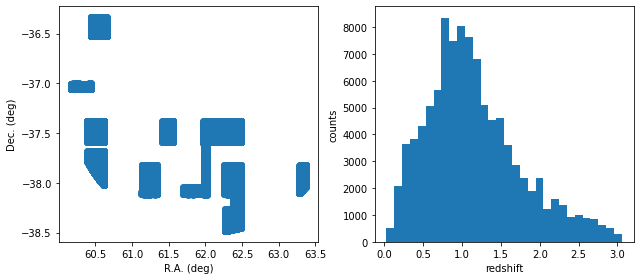

In [17]:
pz_plots.specz_plots(specz_catalog)

## 2. Training and Validation Sets 
#### List Training and Validation Sets available on Pz Server

Training and Validation (or Test) Sets are the product of matching (spatially) a given Spec-z Catalog (single survey or compilation) to the photometric data, in this case, the LSST Objects Catalog. In fact, in most cases, the Training and Validation Sets are just the result of splitting the product of matching into two parts. Hence, the Training and Validation Sets are usually found together. In the case of simulations, the Training and Validation Sets can be just a selection from the simulated catalog that contains the true redshifts and the photometric data required to train and validate the photo-z algorithms.

In the Photo-z Server, there is no dependency between these two products. Users can upload Training and Validation Sets separately, even though they are very similar in format and contents. For each pair of Training and Validation Sets, the user will perform two uploads and, consequently, two new entries will be added to the database. 

_Note 1: There is an ambiguity between the so-called Validation and Test sets found in the literature. In some cases, it is just a matter of terminology, and both play the same role: be used for computing the photo-z metrics as an independent sample from that used for training. In other cases, when the training procedure has a recursive optimization method, the three sets of Training/Validation/Test are distinct, and each one plays a different role. In the context of the PZ Server, there is no distiction between Validation or Test sets. The users are responsible for giving information on how to interpret the subsets on the description field._


  
_Note 2: The Training and Validation Sets supported by the PZ Server are only those used by algorithms that work on the catalog level. Training and Validation Sets for image-based methods, such as image-based deep-learning algorithms are not supported._


Mandatory column: 
* Spectroscopic (or true) redshift - `float`

Other expected columns
* Object ID from LSST Objects Catalog - `integer`
* Observables: magnitudes (and/or colors, or fluxes) from LSST Objects Catalog - `float`
* Observable errors: magnitude errors (and/or color errors, or flux errors) from LSST Objects Catalog - `float`
* Right ascension [degrees] - `float`
* Declination [degrees] - `float`
* Quality Flag - `integer`, `float`, or `string`




#### List Training and Validation Sets available on PZ Server

In [18]:
pz_server.display_products_list(filters={"product_type": "Training Set"})

id,internal_name,product_name,product_type,survey,release,uploaded_by,official_product,description,created_at
16,16_goldenspike_train,goldenspike train,Training Set,None,None,Gschwend,False,Training set created with RAIL's goldenspike example notebook (simulated data). Test upload FITS file.,2022-10-28T12:55:31.431617Z
14,14_goldenspike_train,goldenspike train,Training Set,None,None,Gschwend,False,Training set created with RAIL's goldenspike example notebook (simulated data). Test upload CSV file.,2022-10-28T12:53:28.365934Z
9,9_train_sample_dp0_tiny,Train sample DP0 tiny,Training Set,LSST,LSST DP0,Gschwend,False,"A subsample of DP0 data with true redshifts and magnitudes to train pz codes. ""DP0 tiny"" means the tiny fraction of DP0 used to test algorithms in the LIneA portal.",2022-10-17T16:04:32.903542Z


In [19]:
pz_server.display_products_list(filters={"product_type": "Validation Set"})

id,internal_name,product_name,product_type,survey,release,uploaded_by,official_product,description,created_at
20,20_goldenspike_test,goldenspike test,Validation Set,,None,Gschwend,False,Validation (test) set created with RAIL's goldenspike example notebook (simulated data). Test upload HDF5 file.,2022-10-28T13:08:32.945942Z
19,19_goldenspike_test,goldenspike test,Validation Set,,None,Gschwend,False,Validation (test) set created with RAIL's goldenspike example notebook (simulated data). Test upload parquet file.,2022-10-28T13:07:03.403975Z
10,10_valid_sample_dp0_tiny,Valid sample DP0 tiny,Validation Set,LSST,LSST DP0,Gschwend,False,"A subsample of DP0 data with true redshifts and magnitudes to validate pz codes. ""DP0 tiny"" means the tiny fraction of DP0 used to test algorithms in the LIneA portal.",2022-10-17T16:05:50.808523Z


#### Display metadata of a given Training Set

In [20]:
metadata_train_set = pz_server.get_product_metadata(9)
pz_server.display_product_metadata("14_goldenspike_train") 

key,value
id,14
release,None
product_type,Training Set
uploaded_by,Gschwend
internal_name,14_goldenspike_train
product_name,goldenspike train
official_product,False
survey,None
pz_code,None
description,Training set created with RAIL's goldenspike example notebook (simulated data). Test upload CSV file.


#### Retrieve a given Training Set 

In [21]:
train_set = pz_server.get_product(9)
train_set

,coadd_objects_id,z_true,ra,dec,extendedness,mag_u,mag_g,mag_r,mag_i,mag_z,...,magerr_y,host_galaxy,is_variable,is_pointsource,truth_type,match_sep,cosmodc2_hp,cosmodc2_id,is_good_match,is_unique_truth_entry
0,13542134963533657,2.888735,59.2224,-43.1165,1.0,26.4664,27.0861,27.1896,28.7258,24.9601,...,1.3945,-1,0,0,1,0.637091,10324,11144924328,NaN,NaN
1,17724148914627425,2.442620,65.1607,-34.4085,1.0,26.7917,26.0648,25.7113,26.3745,NaN,...,1.7678,-1,0,0,1,0.142159,9559,6078590791,NaN,NaN
2,15169558201526293,0.903213,64.1627,-39.7390,1.0,23.8507,23.8086,23.5156,22.8162,22.5516,...,0.0423,-1,0,0,1,0.005448,10071,9751712976,NaN,NaN
3,19522949937651800,2.238752,70.3545,-31.6238,1.0,30.1923,26.3643,26.3924,25.8560,25.4158,...,3.4369,-1,0,0,1,0.067408,9305,4451811952,NaN,NaN
4,13528683125962810,0.964644,53.8986,-42.2352,1.0,25.9495,25.9838,26.1769,25.7605,25.5615,...,0.5494,-1,0,0,1,0.136472,10195,10314699643,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,15987594852607080,1.640293,57.3749,-38.1166,0.0,28.2771,26.5467,26.7667,25.9502,26.4440,...,0.6452,-1,0,0,1,0.044824,9940,8756627679,NaN,NaN
9995,19492554454105242,0.696520,57.3173,-32.7131,1.0,25.4590,23.9227,22.6473,21.6995,21.1584,...,0.0212,-1,0,0,1,0.027474,9428,5001003552,NaN,NaN
9996,16822828552723102,1.240769,51.5580,-35.7253,1.0,26.0985,26.2160,25.8924,25.2607,24.9174,...,0.2339,-1,0,0,1,0.312382,9682,6753706815,NaN,NaN
9997,13572929879058950,0.924772,73.3471,-42.5213,1.0,23.5871,23.9571,23.3510,22.8285,22.5604,...,0.1785,-1,0,0,1,0.196441,10329,11439432956,NaN,NaN


Display basic statistics

In [22]:
train_set.describe()

,coadd_objects_id,z_true,ra,dec,extendedness,mag_u,mag_g,mag_r,mag_i,mag_z,...,magerr_y,host_galaxy,is_variable,is_pointsource,truth_type,match_sep,cosmodc2_hp,cosmodc2_id,is_good_match,is_unique_truth_entry
count,9.999000e+03,9999.000000,9999.000000,9999.000000,9892.000000,8329.000000,9793.000000,9886.000000,9792.000000,9170.000000,...,9590.000000,9999.0,9999.0,9999.0,9999.0,9999.000000,9999.000000,9.999000e+03,0.0,0.0
mean,1.718753e+16,1.224038,61.775054,-36.030564,0.791347,26.433089,26.182955,25.768208,25.390434,25.075614,...,1.587689,-1.0,0.0,0.0,1.0,0.169837,9702.174517,7.086757e+09,NaN,NaN
std,2.886460e+15,0.633686,6.242792,4.970892,0.406367,1.604394,1.394653,1.395002,1.536526,1.671791,...,228.805208,0.0,0.0,0.0,0.0,0.231012,433.996526,2.913508e+09,NaN,NaN
min,1.273674e+16,0.027218,49.658100,-44.601700,0.000000,20.058700,18.908700,17.843100,17.317700,16.996300,...,-8449.606100,-1.0,0.0,0.0,1.0,0.000338,8788.000000,1.380148e+09,NaN,NaN
25%,1.436472e+16,0.769900,56.564450,-40.341600,1.000000,25.590600,25.537300,25.195075,24.688075,24.264775,...,0.139150,-1.0,0.0,0.0,1.0,0.048329,9304.000000,4.390120e+09,NaN,NaN
50%,1.686282e+16,1.125280,61.607500,-36.002400,1.000000,26.407600,26.338600,26.012450,25.591300,25.214150,...,0.366700,-1.0,0.0,0.0,1.0,0.103112,9687.000000,7.063516e+09,NaN,NaN
75%,1.950988e+16,1.608107,67.027050,-31.862950,1.000000,27.204000,26.912900,26.584050,26.258850,25.986650,...,0.753975,-1.0,0.0,0.0,1.0,0.202160,10070.000000,9.700004e+09,NaN,NaN
max,2.231653e+16,3.041415,74.047000,-26.965900,1.000000,37.880700,35.075500,36.904400,33.813700,32.970900,...,18567.570000,-1.0,0.0,0.0,1.0,3.124385,10452.000000,1.207785e+10,NaN,NaN


Quick visualization of training/validation sets properties. The function `train_valid_plots` can receive a single input: 

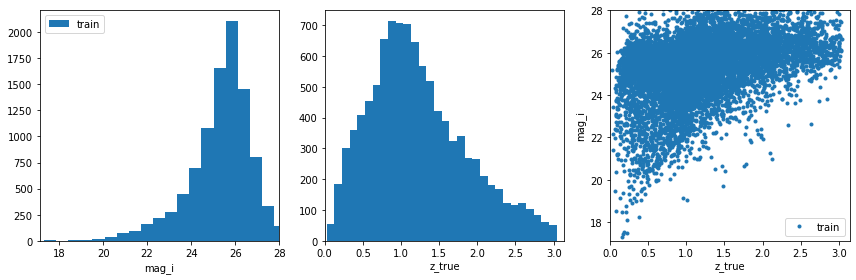

In [23]:
pz_plots.train_valid_plots(train=train_set, mag_name="mag_i", redshift_name="z_true")

Or separate training and validation samples for comparison: 

In [24]:
valid_set = pz_server.get_product(10)

'train_valid_set.png'

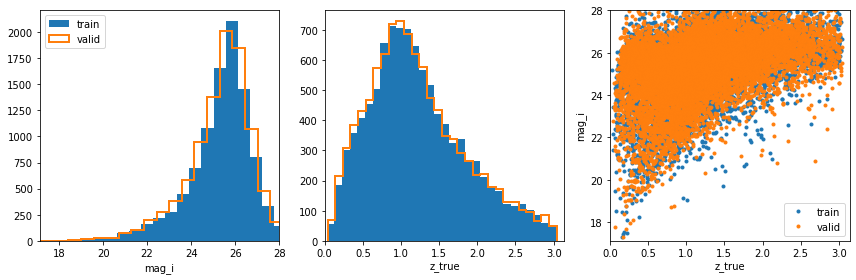

In [25]:
pz_plots.train_valid_plots(train=train_set, valid=valid_set, mag_name="mag_i", redshift_name="z_true", savefig=True) 

## 4. Photo-z Validation Results

Validation Results are the outputs of any photo-z algorithm applied on a Validation Set. The format and number of files of this data product are strongly dependent on the algorithm used to create it, so there are no constraints on these two parameters. In the case of multiple files, for instance, if the user includes the results of training procedures (e.g., neural nets weights, decision trees files, or any machine learning by-product) or additional files (SED templates, filter transmission curves, theoretical magnitudes grid, Bayesian priors, etc.), it will be required to put all files together in a single compressed file (.zip or .tar, or .tar.gz) before uploading it to the Photo-z Server.   

#### List Validation Results available on PZ Server

In [26]:
pz_server.display_products_list(filters={"product_type": "Validation Results"})

id,internal_name,product_name,product_type,survey,release,uploaded_by,official_product,description,created_at
24,24_pz_validation_goldenspike_knn,pz validation goldenspike knn,Validation Results,None,None,Gschwend,False,Results of photoz validation created with RAIL's goldenspike example notebook. Test upload zip file.,2022-10-28T14:36:55.899181Z
22,22_pz_validation_goldenspike_bpz,pz validation goldenspike bpz,Validation Results,None,None,Gschwend,False,Results of photoz validation created with RAIL's goldenspike example notebook. Test upload zip file.,2022-10-28T14:19:41.936586Z
21,21_pz_validation_goldenspike_fzboost,pz validation goldenspike fzboost,Validation Results,None,None,Gschwend,False,Results of photoz validation created with RAIL's goldenspike example notebook. Test upload zip file.,2022-10-28T14:02:18.647278Z


#### Display metadata of a given data product of Photo-z Validation Results

In [27]:
pz_server.display_product_metadata(21)

key,value
id,21
release,None
product_type,Validation Results
uploaded_by,Gschwend
internal_name,21_pz_validation_goldenspike_fzboost
product_name,pz validation goldenspike fzboost
official_product,False
survey,None
pz_code,flexzboost
description,Results of photoz validation created with RAIL's goldenspike example notebook. Test upload zip file.


#### Retrieve a given Photo-z Validation Results: download file

This product type is not necessarily (only) tabular data and can be a list of files. The function `get_product` shown above just return the data to be used on memory and only supports single tabular files. To retrieve Photo-z Validation Results, you must download the data to open locally. 

In [28]:
pz_server.download_product(21)

{'success': False,
 'message': 'Request Error: Expecting value: line 1 column 1 (char 0)'}

## 5. Photo-z Tables 

The Photo-z Tables are the results of photo-z estimation on photometrics samples. The size limit for uploading files on the PZ Server is 200MB, therefore it does not support large Photo-z Tables such as the photo-zs of the LSST Objects catalog. Instead, the PZ Server can host only Photo-z Tables of small data sets.

In [29]:
#pz_server.download_product(<id number or internal name>)